0. Описать задачу словами
1. Прочитать данные
2. Визуализировать данные и вычислить основные характеристики (среднее, разброс, корреляционную матрицу и т.д.). Интерпретировать.
3. Обработать пропущенные значения (или убедиться, что их нет)
4. Обработать категориальные признаки
5. Провести нормализацию (или объяснить, почему в вашем случае она не нужна)
6. Разбить данные на обучающую и тестовую выборки
7. Запустить классификатор (ререссию) ближайших соседей или другой метод (аргументируйте выбор!)
8. Вычислить ошибки на обучающей и тестовой выборках. Выбрать оптимальное значение гиперпараметра (к-ва ближайших соседей) Сделать выводы
9. По желанию: запустить другие классификаторы. Сравнить результаты
10. По желанию: как-то побороться с несбалансированностью классов (если она есть)
11. По желанию: исключить коррелированные переменные (объяснить зачем)
12. Сделать общие выводы

# 0. Описать задачу словами

Задача классификации: по медицинским данным будем определять наличие диабета


# 1. Прочитать данные


In [56]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight
from scipy import stats
from sklearn.metrics import accuracy_score
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split


%matplotlib inline

Загрузим данные

In [57]:
path = 'diabetes_prediction_dataset.csv'
data = pd.read_csv(path, sep=',')

In [58]:
data.shape

(100000, 9)

In [59]:
data.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [60]:
data.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'smoking_history',
       'bmi', 'HbA1c_level', 'blood_glucose_level', 'diabetes'],
      dtype='object')

Смысл столбцов:


*   `gender` - пол
*   `age` - возраст
*   `hypertension` - наличие гипертонии
*   `heart_disease` - наличие болезней сердца
*   `smoking_history` - история курения
*   `bmi` - индес массы тела (ИМТ)
*   `HbA1c_level` - уровень гликированного гемоглобина в крови
*   `blood_glucose_level` - уровень глюкозы в крови
*   `diabetes` - наличие диабета





# 2. Визуализировать данные и вычислить основные характеристики (среднее, разброс, корреляционную матрицу и т.д.). Интерпретировать.

## Проверим исходные данные

In [61]:
data['gender'].value_counts()

,count
gender,
Female,58552
Male,41430
Other,18


Удалим строки с невалижной информацей (Other)

In [62]:
data = data.drop(data[data.gender == 'Other'].index)
data['gender'].value_counts()

,count
gender,
Female,58552
Male,41430


In [63]:
data['smoking_history'].value_counts()

,count
smoking_history,
No Info,35810
never,35092
former,9352
current,9286
not current,6439
ever,4003


У многих людей(~35%) отсутсвует информация о курении

In [64]:
data['hypertension'].value_counts()

,count
hypertension,
0,92497
1,7485


In [65]:
data['heart_disease'].value_counts()

,count
heart_disease,
0,96040
1,3942


## Визуализируем категориальные признаки

In [66]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
age,99982.0,41.888076,22.517206,0.08,24.00,43.00,60.00,80.00
hypertension,99982.0,0.074863,0.263172,0.00,0.00,0.00,0.00,1.00
heart_disease,99982.0,0.039427,0.194610,0.00,0.00,0.00,0.00,1.00
bmi,99982.0,27.320757,6.636853,10.01,23.63,27.32,29.58,95.69
HbA1c_level,99982.0,5.527529,1.070665,3.50,4.80,5.80,6.20,9.00
blood_glucose_level,99982.0,138.057810,40.709469,80.00,100.00,140.00,159.00,300.00
diabetes,99982.0,0.085015,0.278906,0.00,0.00,0.00,0.00,1.00


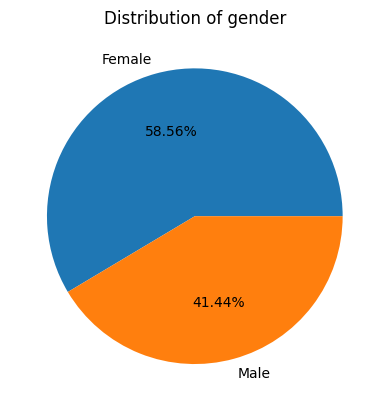

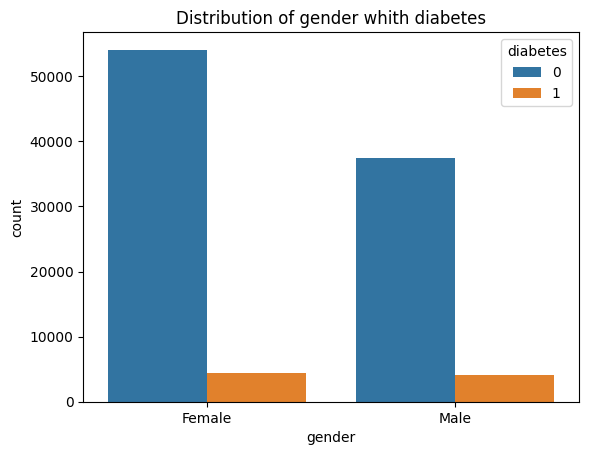

In [67]:
plt.title('Distribution of gender')
plt.pie(data['gender'].value_counts().values, labels = list(data['gender'].unique()), autopct = '%.2f%%')
plt.show()

sns.countplot(x = data.gender, data = data, hue = 'diabetes')
plt.title('Distribution of gender whith diabetes')
pass

Женщины обращались чаще, однако диабет у них встречался реже чем у мужчин

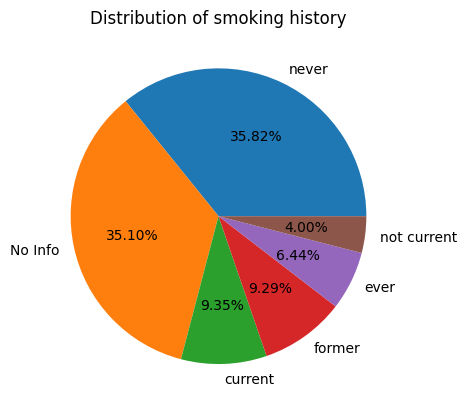

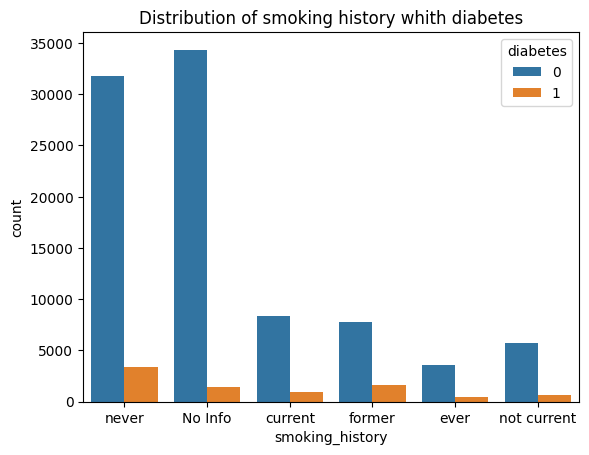

In [68]:
plt.title('Distribution of smoking history')
plt.pie(data['smoking_history'].value_counts().values, labels = list(data['smoking_history'].unique()), autopct = '%.2f%%')
plt.show()

plt.title('Distribution of smoking history whith diabetes')
sns.countplot(x = data.smoking_history, data = data, hue = 'diabetes')
plt.show()

Люди когда либо курившие чаще болеют диабетом

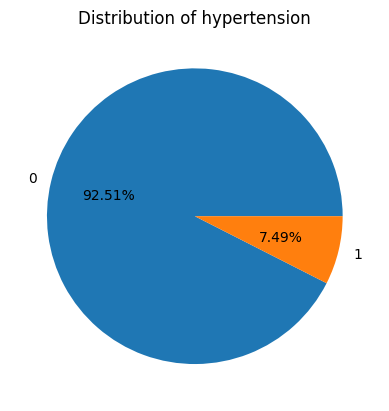

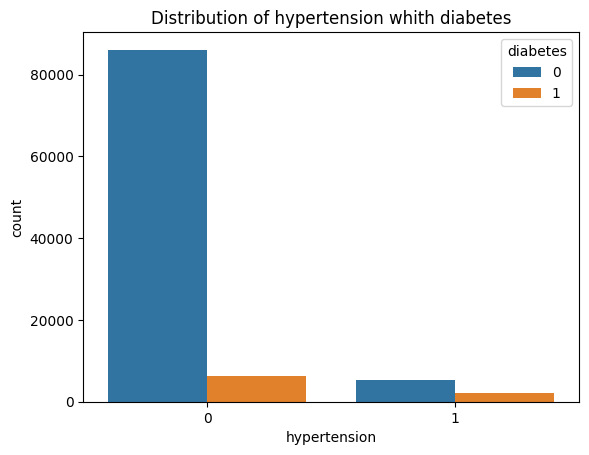

In [69]:
plt.title('Distribution of hypertension')
plt.pie(data['hypertension'].value_counts().values, labels = list(data['hypertension'].unique()), autopct = '%.2f%%')
plt.show()

plt.title('Distribution of hypertension whith diabetes')
sns.countplot(x = data.hypertension, data = data, hue = 'diabetes')
plt.show()

Люди болеющие гипертонией также чаще болеют и диабетом

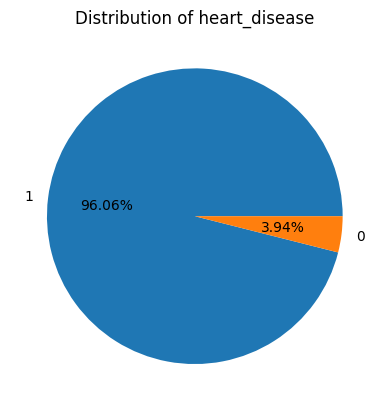

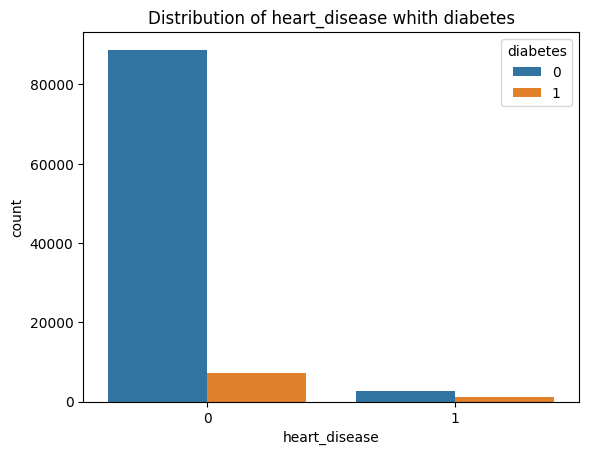

In [70]:
plt.title('Distribution of heart_disease')
plt.pie(data['heart_disease'].value_counts().values, labels = list(data['heart_disease'].unique()), autopct = '%.2f%%')
plt.show()

plt.title('Distribution of heart_disease whith diabetes')
sns.countplot(x = data.heart_disease, data = data, hue = 'diabetes')
plt.show()

Из гистограммы видно, что люди с болезнями сердца также чаще болеют и диабетом

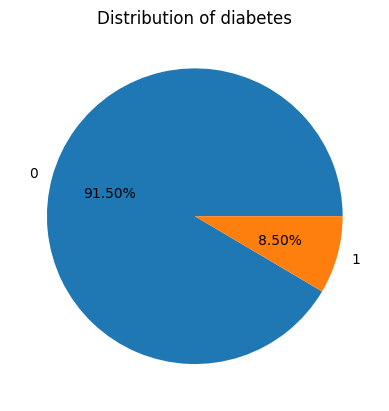

In [71]:
plt.title('Distribution of diabetes')
plt.pie(data['diabetes'].value_counts().values, labels = list(data['diabetes'].unique()), autopct = '%.2f%%')
plt.show()

Классы несбалансированы

## Матрица корреляции

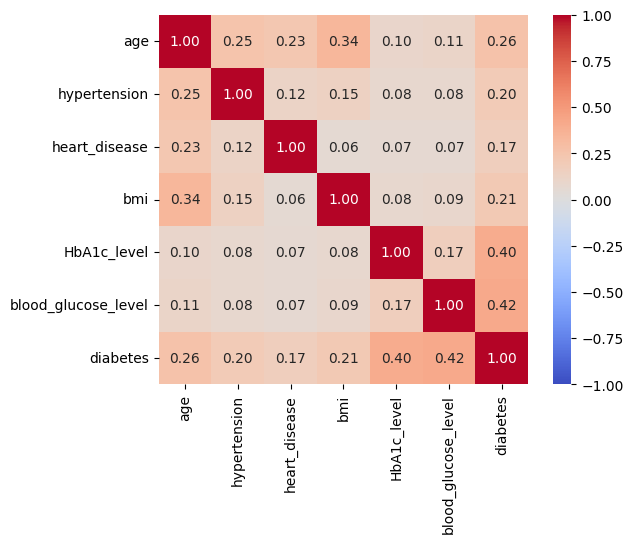

In [72]:
corr_mat = data.corr(numeric_only=True)
sns.heatmap(corr_mat, square=True, annot=True, fmt='.2f', vmin=-1, vmax=1, cmap='coolwarm')
pass

Средняя корреляция диабета наблюдается с уровнем глюкозы(blood_glucose_level) и гликированного гемоглобина(HbA1c_level) в крови и слабая с остальными признаками

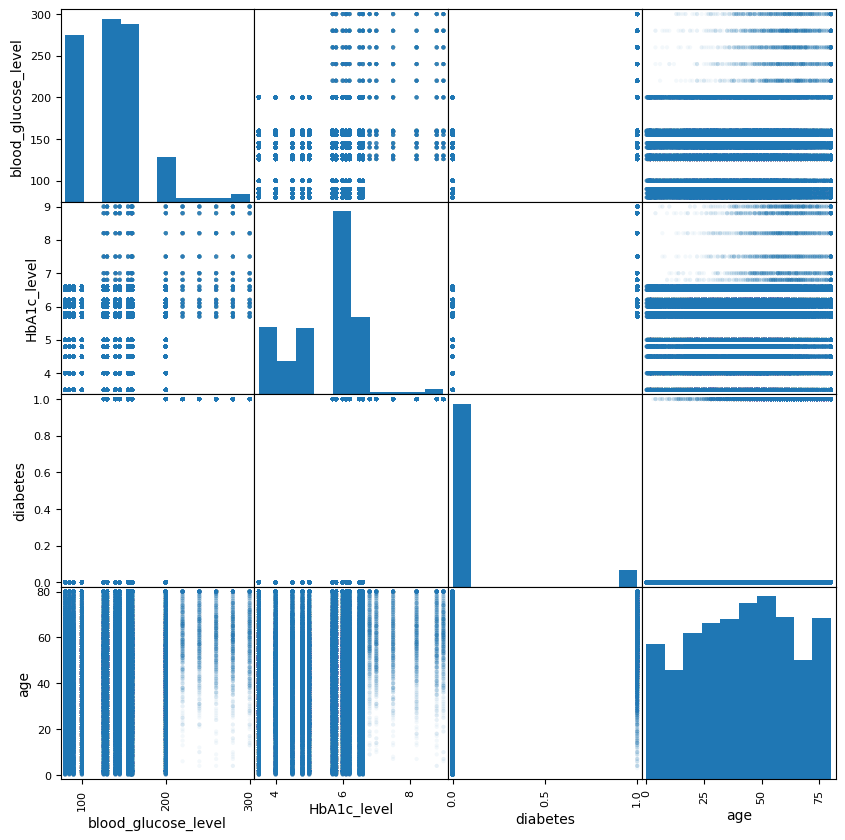

In [73]:
from pandas.plotting import scatter_matrix
corr_data = data[['blood_glucose_level','HbA1c_level', 'diabetes', 'age']]
scatter_matrix(corr_data, alpha = .05, figsize = (10, 10))
pass

Исходя из графиов можно сделать следующие выводы:

*   У большинства людей уровень глюозы в крови меньше 200
*   У большинства людей уровень гликированного гемоглобина в крови меньше 7
*   Между уровень глюозы и уровенём гликированного гемоглобина есть связь
*   Почти всем людям в выборке больше 25 лет
*   У молодых людей (до 25 лет) реже встречается диабет


Также можно заметить, что при большём уровенём гликированного гемоглобина диабет не встречается и при достаточно малых значениях этого параметра он встречается достаточно часто. Противоположная ситуация видна с уровнем глюозы.

## Раасмотрим взимосвязь уровня гликированного гемоглобина, глюозы и диабета

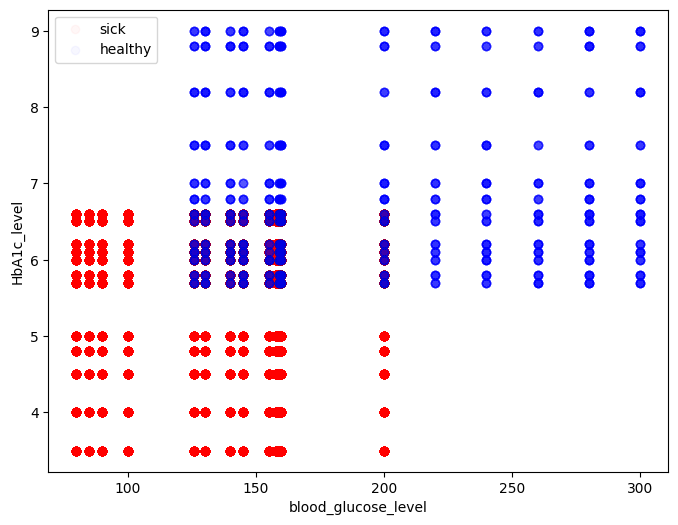

In [74]:
plt.figure(figsize=(8, 6))
sick = data[data['diabetes'] == 0]
healthy = data[data['diabetes'] == 1]
plt.scatter(x = sick['blood_glucose_level'].values, y = sick['HbA1c_level'].values, alpha = 0.03, c='r', label='sick')
plt.scatter(x = healthy['blood_glucose_level'].values, y = healthy['HbA1c_level'].values, alpha = 0.03, c='b', label='healthy')
plt.xlabel('blood_glucose_level')
plt.ylabel('HbA1c_level')
plt.legend()
plt.show()

Из диаграммы рассеивания видно, что наличие диабета можно однозначно опредилить вне области (125, 200) по уровеню глюозы  и (5, 7) по уровеню гемоглобина

# 3. Обработаем выбросы

,age
count,99982.000000
mean,41.888076
std,22.517206
min,0.080000
25%,24.000000
50%,43.000000
75%,60.000000
max,80.000000


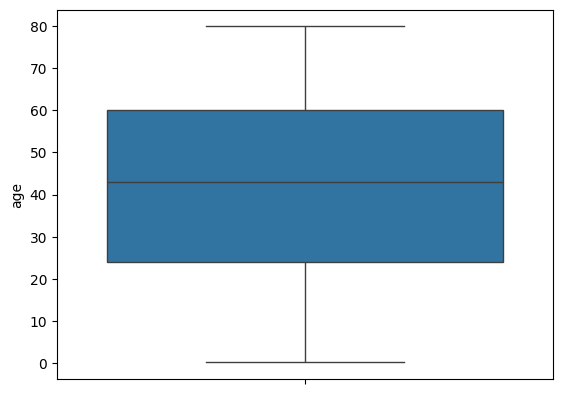

In [75]:
sns.boxplot(data['age'])
data['age'].describe()

,bmi
count,99982.000000
mean,27.320757
std,6.636853
min,10.010000
25%,23.630000
50%,27.320000
75%,29.580000
max,95.690000


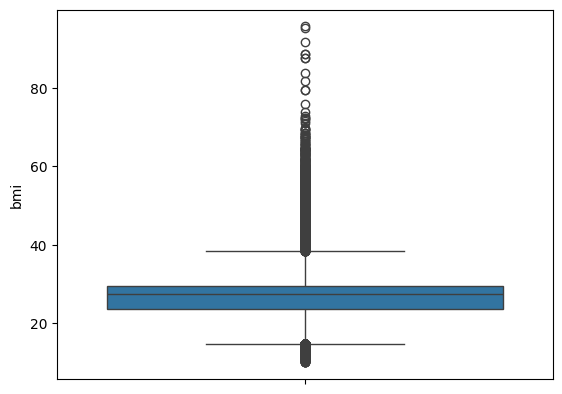

In [76]:
sns.boxplot(data['bmi'])
data['bmi'].describe()

In [77]:
data['bmi'].quantile(0.98)

44.8

<Axes: ylabel='bmi'>

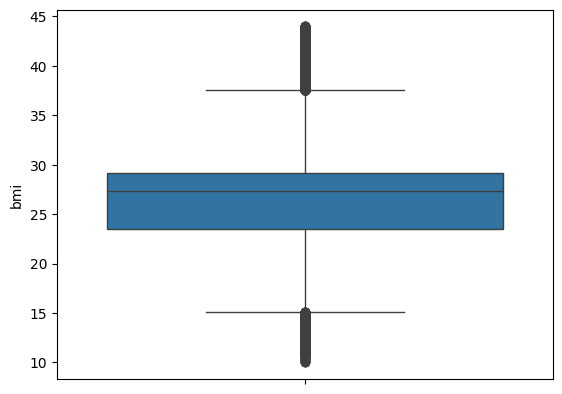

In [78]:
data = data[data['bmi'] < 44]
sns.boxplot(data['bmi'])

,HbA1c_level
count,97670.000000
mean,5.521194
std,1.066272
min,3.500000
25%,4.800000
50%,5.800000
75%,6.200000
max,9.000000


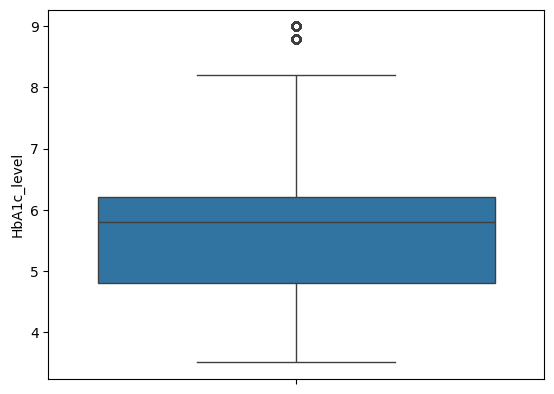

In [79]:
sns.boxplot(data['HbA1c_level'])
data['HbA1c_level'].describe()

In [80]:
data['HbA1c_level'].quantile(0.99)

8.8

<Axes: ylabel='HbA1c_level'>

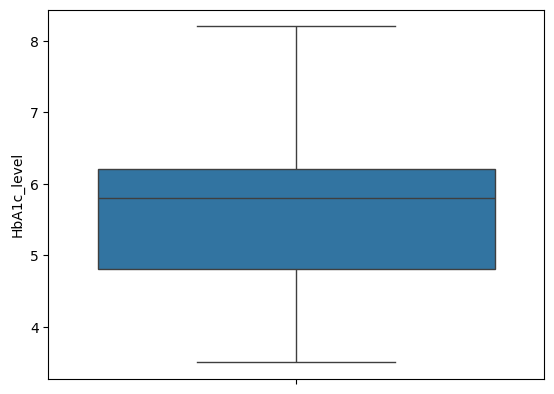

In [81]:
data = data[data['HbA1c_level'] < 8.8]
sns.boxplot(data['HbA1c_level'])

,blood_glucose_level
count,96440.000000
mean,137.102281
std,39.673130
min,80.000000
25%,100.000000
50%,140.000000
75%,159.000000
max,300.000000


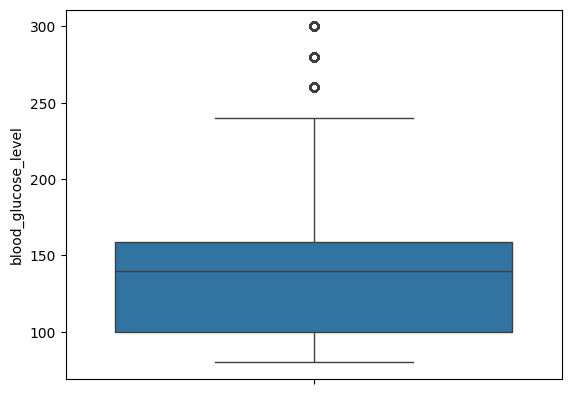

In [82]:
sns.boxplot(data['blood_glucose_level'])
data['blood_glucose_level'].describe()

In [83]:
data['blood_glucose_level'].quantile(0.98)

240.0

<Axes: ylabel='blood_glucose_level'>

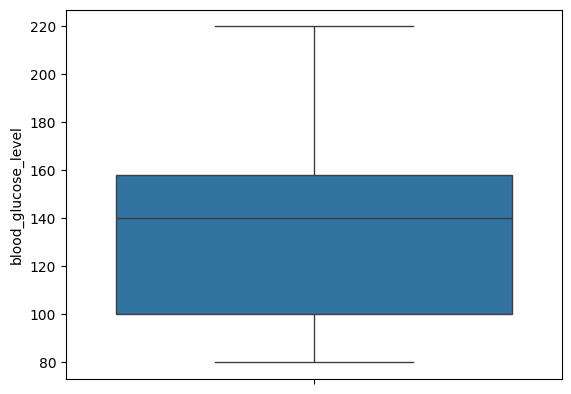

In [84]:
data = data[data['blood_glucose_level'] < 240]
sns.boxplot(data['blood_glucose_level'])

# 4. Обработать категориальные признаки

In [85]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 94313 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   gender               94313 non-null  object 
 1   age                  94313 non-null  float64
 2   hypertension         94313 non-null  int64  
 3   heart_disease        94313 non-null  int64  
 4   smoking_history      94313 non-null  object 
 5   bmi                  94313 non-null  float64
 6   HbA1c_level          94313 non-null  float64
 7   blood_glucose_level  94313 non-null  int64  
 8   diabetes             94313 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 7.2+ MB


Пол будем представлять в виде булевого значения (Male = True, Female = False), а для истории курения применим One-Hot кодирование

In [86]:
data.gender = data['gender'] == 'Male'
data = pd.get_dummies(data, 'smoking_history')
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
Index: 94313 entries, 0 to 99999
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   gender                       94313 non-null  bool   
 1   age                          94313 non-null  float64
 2   hypertension                 94313 non-null  int64  
 3   heart_disease                94313 non-null  int64  
 4   bmi                          94313 non-null  float64
 5   HbA1c_level                  94313 non-null  float64
 6   blood_glucose_level          94313 non-null  int64  
 7   diabetes                     94313 non-null  int64  
 8   smoking_history_No Info      94313 non-null  bool   
 9   smoking_history_current      94313 non-null  bool   
 10  smoking_history_ever         94313 non-null  bool   
 11  smoking_history_former       94313 non-null  bool   
 12  smoking_history_never        94313 non-null  bool   
 13  smoking_history_not c

,gender,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes,smoking_history_No Info,smoking_history_current,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not current
0,False,80.0,0,1,25.19,6.6,140,0,False,False,False,False,True,False
1,False,54.0,0,0,27.32,6.6,80,0,True,False,False,False,False,False
2,True,28.0,0,0,27.32,5.7,158,0,False,False,False,False,True,False
3,False,36.0,0,0,23.45,5.0,155,0,False,True,False,False,False,False
4,True,76.0,1,1,20.14,4.8,155,0,False,True,False,False,False,False


# 5. Провести нормализацию (или объяснить, почему в вашем случае она не нужна)

Проведём нормализацию

In [87]:
X = data.drop(['diabetes'], axis=1)
Y = data['diabetes']

scaler = StandardScaler()
scaler.fit(X)
X = pd.DataFrame(scaler.transform(X), columns=X.columns, index=X.index)

# 6. Разбить данные на обучающую и тестовую выборки

In [88]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# 7. Запустить классификатор (ререссию) ближайших соседей или другой метод (аргументируйте выбор!)

In [89]:
KNN = KNeighborsClassifier(n_neighbors=5)
KNN.fit(X_train, y_train)
err_train = 1 - KNN.score(X_train, y_train)
err_test = 1 - KNN.score(X_test, y_test)
print(err_train, err_test)

0.03159708416169649 0.03679160260828074


# 8. Вычислить ошибки на обучающей и тестовой выборках. Выбрать оптимальное значение гиперпараметра (к-ва ближайших соседей) Сделать выводы

Воспользуемся перебором гиперпараметров для выбора оптимального к-ва ближайших соседей

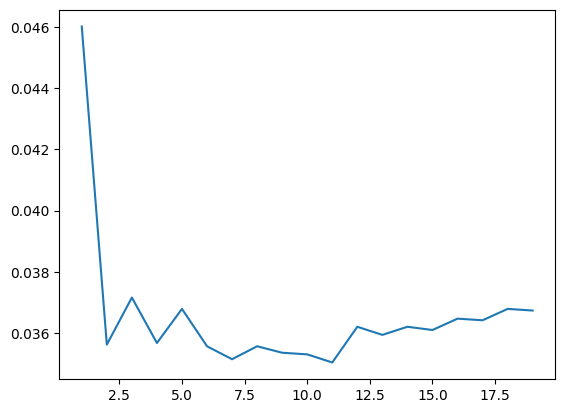

In [90]:
neighbors = range(1, 20)
errs = []
for n in neighbors:
    KNN = KNeighborsClassifier(n_neighbors=n)
    KNN.fit(X_train, y_train)
    errs.append(1 - KNN.score(X_test, y_test))

plt.plot(neighbors, errs)
plt.show()

In [91]:
n = errs.index(min(errs)) + 1
print(n, min(errs))

11 0.03504214600010602


In [92]:
KNN = KNeighborsClassifier(n_neighbors=n)
KNN.fit(X_train, y_train)
err_train = 1 - KNN.score(X_train, y_train)
err_test = 1 - KNN.score(X_test, y_test)
print(err_train, err_test)

0.03618290258449308 0.03504214600010602


Ошибка на тестовой выборке стала незначительно меньше с выбором оптимального гиперпараметра

# 9. По желанию: запустить другие классификаторы. Сравнить результаты

## Классификатор Ridge



In [93]:
clf = RidgeClassifier()
clf.fit(X_train, y_train)

err_train = 1 - clf.score(X_train, y_train)
err_test = 1 - clf.score(X_test, y_test)
print(err_train, err_test)

0.04840291583830347 0.04527381646609763


Классификатор Ridge дал результат хуже чем классификатор ближайших соседей

## Классификатор Extra trees

In [94]:
clf = ExtraTreesClassifier(n_estimators=300, random_state=0)
clf.fit(X_train, y_train)

err_train = 1 - clf.score(X_train, y_train)
err_test = 1 - clf.score(X_test, y_test)
print(err_train, err_test)

0.0008482438701126194 0.030429942214918126


Классификатор Extra trees дал результат лучше чем классификатор ближайших соседей

## Классификатор Random forest

Так как классы являются несбалансированными стоит попробовать ансамблевые методы, которые могут эффективно учитывать дисбаланс классов

In [95]:
clf = RandomForestClassifier(n_estimators=600)
clf.fit(X_train, y_train)

err_test = 1 - clf.score(X_test, y_test)
err_test

0.02899856862641148

Классификатор Random forest дал результат лучше чем классификатор ближайших соседей.
Попробуем ансамбль классификаторов Random forest

In [96]:
ensemble = [RandomForestClassifier(n_estimators=600) for _ in range(10)]

for model in ensemble:
    sample_indices = np.random.choice(len(X_train), size=len(X_train)//2, replace=True)
    X_subset, y_subset = X_train.iloc[sample_indices], y_train.iloc[sample_indices]
    model.fit(X_subset, y_subset)

predictions = np.array([model.predict(X_test) for model in ensemble])
ensemble_predictions = stats.mode(predictions, keepdims=True)[0][0]

err_test = 1 - accuracy_score(y_test, ensemble_predictions)
err_test

0.026825001325345932

Использование ансамбля не принесло результатов)

# 12. Сделать общие выводы

В ходе решения задачи был проведён анализ данных и получены различные модели для предсказания диабета. Наилучшая из полученных моделей выявляет диабет с ошибкой не более 3%. Для улучшения полученных результатов нужно побороться с несбалансированностью классов, например увеличить выборку людей с диабетом (уменьшение выборки может ухудшить полученные результаты). Также можно попробывать увеличить количество признаков и при этом использовать метод главных компонент, чтобы размерность не была слишом большой

# Дополнение: Борьба с дисбалансом

Для борьбы с дисбалансом классов есть следующие подходы:


*   Взвешивание классов
*   Увеличение выборки (этот вариант нам не доступен)
*   Уменьшение выборки


## Взвешивание классов

Используем взвешивание классов для классификатора, показавшего лучший резулбтат - Random forest

In [97]:
class_weights = compute_class_weight('balanced', classes=np.unique(Y), y=Y)

clf_1 = RandomForestClassifier(n_estimators=600)
clf_2 = RandomForestClassifier(n_estimators=600, class_weight=dict(enumerate(class_weights)))
clf_1.fit(X_train, y_train)
clf_2.fit(X_train, y_train)


err_test_1 = 1 - clf_1.score(X_test, y_test)
err_test_2 = 1 - clf_2.score(X_test, y_test)
print(err_test_1, err_test_2)

0.02899856862641148 0.029528706992525078


Взвешевание классов не дает улучшения результатов

## Уменьшение выборки

Попробуем уменьшить выборку

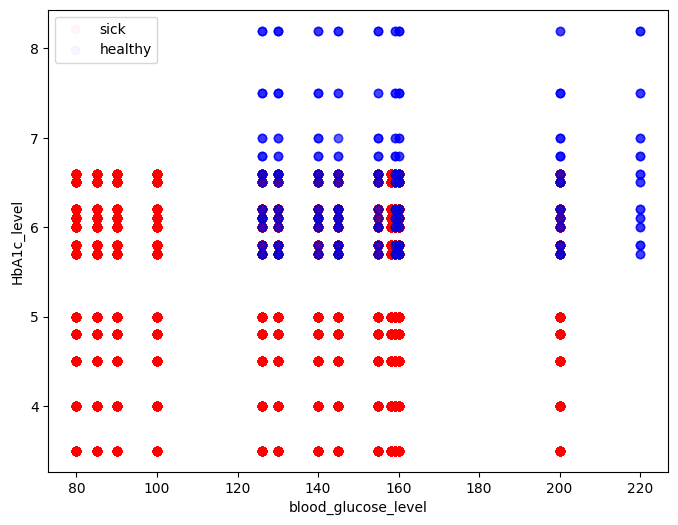

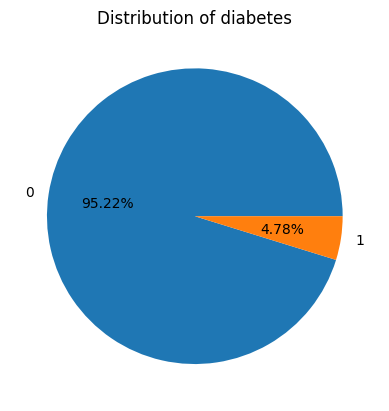

,count
diabetes,
0,89806
1,4507


In [98]:
plt.figure(figsize=(8, 6))
sick = data[data['diabetes'] == 0]
healthy = data[data['diabetes'] == 1]
plt.scatter(x = sick['blood_glucose_level'].values, y = sick['HbA1c_level'].values, alpha = 0.03, c='r', label='sick')
plt.scatter(x = healthy['blood_glucose_level'].values, y = healthy['HbA1c_level'].values, alpha = 0.03, c='b', label='healthy')
plt.xlabel('blood_glucose_level')
plt.ylabel('HbA1c_level')
plt.legend()
plt.show()


plt.title('Distribution of diabetes')
plt.pie(data['diabetes'].value_counts().values, labels = list(data['diabetes'].unique()), autopct = '%.2f%%')
plt.show()
data.diabetes.value_counts()

In [99]:
data_filter_1 = data.query('HbA1c_level < 5.5 | blood_glucose_level < 125')
data_filter_1.diabetes.value_counts()

,count
diabetes,
0,53379


Гипотеза о том, что при HbA1c_level < 5.5 или blood_glucose_level < 125 люди не болеют диабетом подтвердилась, поэтому будем рассматривать оставшиеся данные

In [100]:
data_filter = data.query('HbA1c_level >= 5.5 & blood_glucose_level >= 125')
data_filter.diabetes.value_counts()

,count
diabetes,
0,36427
1,4507


Классы остались не сбалансированными, но ситуация стала немного лучше

In [101]:
X = data_filter.drop(['diabetes'], axis=1)
Y = data_filter['diabetes']

scaler = StandardScaler()
scaler.fit(X)
X = pd.DataFrame(scaler.transform(X), columns=X.columns, index=X.index)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [102]:
class_weights = compute_class_weight('balanced', classes=np.unique(Y), y=Y)

clf = RandomForestClassifier(n_estimators=600, class_weight=dict(enumerate(class_weights)))
clf.fit(X_train, y_train)

err_test = 1 - clf.score(X_test, y_test)
err_test

0.0664468059118114

Ошибка при уменьшении выборки увеличилась примерно в 2 раза (примерно столько же данных мы удалили), значит модель обученная на большем наборе данных давала на этих(удалённых) данных правильные результаты и ошибалась в основном в области (125, 200) по уровеню глюозы и (5, 7) по уровеню гемоглобина. Скорее всего нам не хватает признаков для обнаружения диабета в этой области